## Data to object conversion

Data source: https://genome.crg.cat/datasets/genomics96/

Vertebrate DNA sequences are presented in `fasta` format. Here is a preview:

```
>ACU08131
CTGGGCTAAAAGGTCCCTTAGCCTATTTAGAAAAATGGGCCATTAGGAAATTGCAAGGAA
GAACCATTCGTGAGAGGGATTAGCTGAGCTCTTTTGACTCTCTAATCACCCCTCCGTGCT
CATCCCTCACCTGAAGTGTCCAGCAAATACACCAAGGGTGACGCAGGACAAGCATGAGCC
...
>AGGGLINE
CAAGGCTGCTGTCACTAGCCTGTGGGGCAAGGTGAATGTGGAAGATGCTGGGGGAGAAAC
CCTGGGAAGGTAGGCTCTGGTGACCAGGACGAGGGAGGGAAGGAAGGAACCTATGCTTGG
CAAAAGTTCAGGCTGCCTCTCAGGATTTGTGGCACCTTCTGACTTTCAAACTGCTATTGT
...
```

An additional file specifies the exon indices for each sequence.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn')

# Dictionary with name:[properties] items
sequences = {}

# Read DNA Sequences
with open('DNASequences.fasta', 'r') as file:
    line = file.readline()
    while len(line) != 0:
        name = line[1:-1]
        seq = []
        line = file.readline()
        while len(line) > 0 and line[0] != '>':
            seq.append(line[:-1])
            line = file.readline()
        sequences[name] = {}
        sequences[name]['sequence'] = ''.join(seq)

# Read Gene Indices
with open('CDS.tbl', 'r') as file:
    line = file.readline()
    while len(line) != 0:
        name, *indices = line.split()
        sequences[name]['indices'] = [int(i) for i in indices]
        line = file.readline()

# Use indices and sequence to extract exons and introns
# Note even the the intergenic regions are not introns, they are stored in the intron array
for name in sequences.keys():
    seq = sequences[name]['sequence']
    all_indexes = [0, *sequences[name]['indices'], len(seq)+1]
    intron = True
    sequences[name]['introns'] = []
    sequences[name]['exons'] = []
    sequences[name]['is_exon'] = np.zeros(len(seq))
    # Alternate between introns and exons
    for i in range(len(all_indexes)-1):
        if intron:
            sequences[name]['introns'].append(seq[all_indexes[i]:all_indexes[i+1]-1])
        else:
            sequences[name]['exons'].append(seq[all_indexes[i]-1:all_indexes[i+1]])
            sequences[name]['is_exon'][all_indexes[i]-1:all_indexes[i+1]] = 1
        intron = not intron
    sequences[name]['gene sequence'] = ''.join(sequences[name]['exons'])
    sequences[name]['gene length'] = len(sequences[name]['gene sequence'])


In [2]:
name = list(sequences.keys())[0]
print(name)
sequences[name]

ACU08131


{'exons': ['ATGGCAGGGACCGTGACGGAAGCCTGGGATGTGGCAGTATTTGCTGCCCGACGGCGCAATGATGAAGACGACACCACAAGGGATAGCTTGTTCACTTATACCAACAGCAACAATACCCGGG',
  'GCCCCTTTGAAGGTCCAAACTATCACATTGCGCCACGCTGGGTCTACAATATCACTTCTGTCTGGATGATTTTTGTGGTCATCGCTTCAATCTTCACCAATGGTTTGGTATTGGTGGCCACTGCCAAATTCAAGAAGCTACGGCATCCTCTGAACTGGATTCTGGTAAACTTGGCGATAGCTGATCTGGGTGAGACGGTTATTGCCAGTACCATCAGTGTCATCAACCAGATCTCTGGCTACTTCATCCTTGGCCACCCTATGTGTGTGCTGGAGGGATACACTGTTTCAACTTGTG',
  'GTATCTCAGCTCTCTGGTCCTTGGCCGTTATATCTTGGGAACGCTGGGTCGTTGTCTGCAAGCCCTTTGGAAATGTCAAGTTCGATGCCAAACTGGCCGTGGCTGGCATTGTCTTCTCCTGGGTGTGGTCTGCTGTATGGACAGCACCACCCGTCTTTGGCTGGAGTAG',
  'GTACTGGCCCCATGGCTTGAAGACCTCATGCGGTCCAGATGTATTCAGTGGCAGTGATGACCCCGGTGTTCTGTCTTACATGATTGTCCTCATGATCACCTGTTGCTTCATTCCCCTGGCTGTCATCCTTCTCTGCTACCTGCAAGTGTGGTTGGCTATCCGTGCG',
  'GTTGCTGCCCAGCAGAAAGAGTCTGAATCTACACAGAAGGCTGAGAAGGAAGTGTCGAGGATGGTGGTAGTCATGATAATTGCCTATTGCTTCTGCTGGGGGCCATATACGGTCTTTGCCTGTTTTGCTGCTGCCAACCCAGGCTATGCCTTCCACCCCCTTGCAGCTGCTCTGCCTGCTTACTTTGCAAAGAGCGCAACTATCTACAACC

## Markov Chain (1st order)

Before implementing a model, we split the dataset into 90% training data and 10% test data.

In [3]:
np.random.seed(800)

# Split into training and test set
names = np.array(list(sequences.keys()))
n = len(names)
p = np.random.permutation(n)

training_names = names[p[:n*9//10]]
test_names = names[p[n*9//10:]]

print('Training set length: {}'.format(len(training_names)))
print('Test set length: {}'.format(len(test_names)))

Training set length: 513
Test set length: 57


The data was found to be incomplete. Here are the letter mappings:

In [4]:
base_map = {'A':'A', 'T':'T', 'G':'G', 'C':'C',
            'R':'AG', 'Y': 'TC', 'M':'AC', 'K':'GT', 'S':'GC', 'W':'AT',
            'H':'ACT', 'B':'GTC', 'V':'GCA', 'D':'GAT', 'N':'ATGC'}

To construct the 1st order Markov chain, we use MLE to determine the transition probabilities. We end up with two transition matrices: one for exons and one for non-coding regions/introns. 

Note: for incomplete nucleotides, we split the likelihood among the possible bases.

In [5]:
# First order Markov chain, compute transition matrix for exons/introns (maximum likelihood estimation)
mm1_transitions = {seq_type:{base:{base2:0 
                                   for base2 in 'ATGC'} 
                             for base in 'ATGC'} 
                   for seq_type in ['exons', 'introns']}

# Count number of transitions
for name in training_names:
    for seq_type in ['exons', 'introns']:
        for subseq in sequences[name][seq_type]:
            for i in range(1, len(subseq)):
                bases1 = base_map[subseq[i-1]]
                bases2 = base_map[subseq[i]]
                multiplier = len(bases1) * len(bases2)
                for base1 in bases1:
                    for base2 in bases2:
                        mm1_transitions[seq_type][base1][base2] += 1/multiplier

# Normalize by dividing by total number of transitions from each base
for seq_type in ['exons', 'introns']:
    for base1 in 'ATGC':
        normalize_factor = sum(mm1_transitions[seq_type][base1].values())
        for base2 in 'ATGC':
            mm1_transitions[seq_type][base1][base2] /= normalize_factor


We calculate the log-likelihood on a single sequence in the test set for both intron transition probabilities and exon transition probabilities using a window size of 100:

In [6]:
# Calculate the likelihood of a sliding window using both exon transition probabilities and intron transition probabilities
# Compare the likelihoods and make a prediction

def predict_mm1(seq, transitions, window=100, plot=False):
    # Log-likelihoods of each transition
    ll_exons = []
    ll_introns = []
    for i in range(1, len(seq)):
        ll_exon = 0
        ll_intron = 0
        bases1 = base_map[seq[i-1]]
        bases2 = base_map[seq[i]]
        for base1 in bases1:
            for base2 in bases2:
                ll_exon += transitions['exons'][base1][base2]
                ll_intron += transitions['introns'][base1][base2]
        ll_exons.append(np.log(ll_exon))
        ll_introns.append(np.log(ll_intron))
        
    # Efficient sliding window algorithm to calculate sum of log-likelihoods 
    s_exon = sum(ll_exons[:window])
    s_intron = sum(ll_introns[:window])
    ll_exons_window_sum = [s_exon]
    ll_introns_window_sum = [s_intron]
    for i in range(window, len(ll_exons)):
        s_exon += ll_exons[i] - ll_exons[i-window]
        ll_exons_window_sum.append(s_exon)
        s_intron += ll_introns[i] - ll_introns[i-window]
        ll_introns_window_sum.append(s_intron)
        
    # Plot log-likelihoods of windows
    if plot:
        fig, ax = plt.subplots()
        ax.plot(ll_exons_window_sum, label='exon')
        ax.plot(ll_introns_window_sum, label='intron')
        ax.legend()
        ax.set_xlabel('Window #')
        ax.set_ylabel('Log likelihood')
        plt.show()
    
    # Convert to prediction
    ll_comparison = np.array(ll_exons_window_sum) > np.array(ll_introns_window_sum)
    mm1_predicted = np.zeros(len(seq))
    for i in range(len(ll_comparison)):
        if ll_comparison[i]:
            mm1_predicted[window//2+i:window+i] = True
    
    return mm1_predicted

Window illustration:

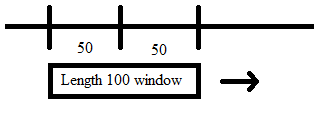

Example 1: RN3B3GLOB

RN3B3GLOB


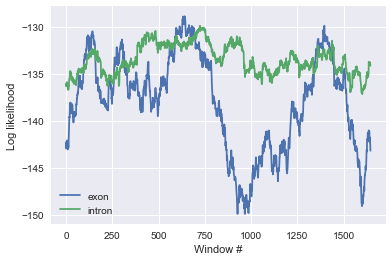

In [7]:
test_name = test_names[6]
print(test_name)
seq = sequences[test_name]['sequence']
mm1_predicted = predict_mm1(seq, mm1_transitions, plot=True)

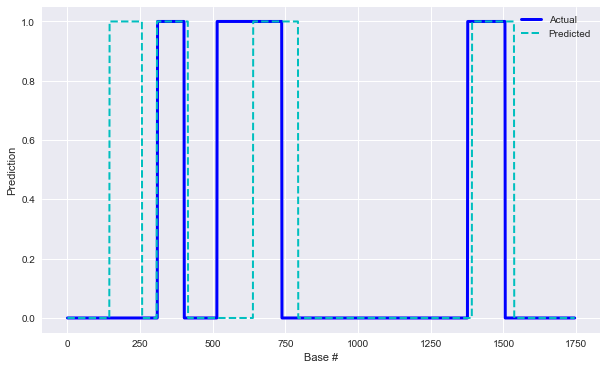

In [8]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(sequences[test_name]['is_exon'], 'b', label='Actual', lw=3)
ax.plot(mm1_predicted, 'c--', label='Predicted', lw=2)
ax.set_xlabel('Base #')
ax.set_ylabel('Prediction')
ax.legend()
plt.show()

Example 2: MMEZGL

MMEZGL


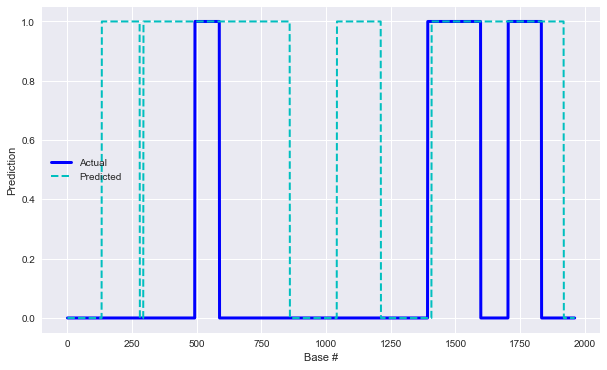

In [9]:
test_name = test_names[5]
print(test_name)
seq = sequences[test_name]['sequence']
mm1_predicted2 = predict_mm1(seq, mm1_transitions)

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(sequences[test_name]['is_exon'], 'b', label='Actual', lw=3)
ax.plot(mm1_predicted2, 'c--', label='Predicted', lw=2)
ax.set_xlabel('Base #')
ax.set_ylabel('Prediction')
ax.legend()
plt.show()

## Markov Chain (2nd order)

In [10]:
import itertools as it

In [11]:
# Second order Markov chain, compute transition matrix for exons/introns (maximum likelihood estimation)
mm2_transitions = {seq_type:{''.join([base, base2]):{base3:0 
                                                     for base3 in 'ATGC'} 
                             for base2 in 'ATGC' for base in 'ATGC'} 
                   for seq_type in ['exons', 'introns']}

# Count number of transitions
for name in training_names:
    for seq_type in ['exons', 'introns']:
        for subseq in sequences[name][seq_type]:
            for i in range(2, len(subseq)):
                bases1 = base_map[subseq[i-2]]
                bases2 = base_map[subseq[i-1]]
                bases3 = base_map[subseq[i]]
                twomers = list(it.product(bases1, bases2))
                multiplier = len(twomers) * len(bases3)
                for base1, base2 in twomers:
                    for base3 in bases3:
                        mm2_transitions[seq_type][''.join([base1, base2])][base3] += 1/multiplier

# Normalize by dividing by total number of transitions from each dimer
for seq_type in ['exons', 'introns']:
    for key in mm2_transitions[seq_type]:
        normalize_factor = sum(mm2_transitions[seq_type][key].values())
        for base in 'ATGC':
            mm2_transitions[seq_type][key][base] /= normalize_factor

In [12]:
def predict_mm2(seq, transitions, window=100, plot=False):
    # Log-likelihoods of each transition
    ll_exons = []
    ll_introns = []
    for i in range(2, len(seq)):
        ll_exon = 0
        ll_intron = 0
        bases1 = base_map[seq[i-2]]
        bases2 = base_map[seq[i-1]]
        bases3 = base_map[seq[i]]
        twomers = list(it.product(bases1, bases2))
        for base1, base2 in twomers:
                for base3 in bases3:
                    ll_exon += transitions['exons'][''.join([base1, base2])][base3]
                    ll_intron += transitions['introns'][''.join([base1, base2])][base3]
        ll_exons.append(np.log(ll_exon))
        ll_introns.append(np.log(ll_intron))

    # Efficient sliding window algorithm to calculate sum of log-likelihoods 
    s_exon = sum(ll_exons[:window])
    s_intron = sum(ll_introns[:window])
    ll_exons_window_sum = [s_exon]
    ll_introns_window_sum = [s_intron]
    for i in range(window, len(ll_exons)):
        s_exon += ll_exons[i] - ll_exons[i-window]
        ll_exons_window_sum.append(s_exon)
        s_intron += ll_introns[i] - ll_introns[i-window]
        ll_introns_window_sum.append(s_intron)  
    
    # Plot log-likelihoods of windows
    if plot:
        fig, ax = plt.subplots()
        ax.plot(ll_exons_window_sum, label='exon ll')
        ax.plot(ll_introns_window_sum, label='intron ll')
        ax.legend()
        ax.set_xlabel('Window #')
        ax.set_ylabel('Log likelihood')
        plt.show()
    
    # Convert to prediction
    ll_comparison = np.array(ll_exons_window_sum) > np.array(ll_introns_window_sum)
    mm2_predicted = np.zeros(len(seq))
    for i in range(len(ll_comparison)):
        if ll_comparison[i]:
            mm2_predicted[window//2+i:window+i] = True

    return mm2_predicted


Example 1: RN3B3GLOB

RN3B3GLOB


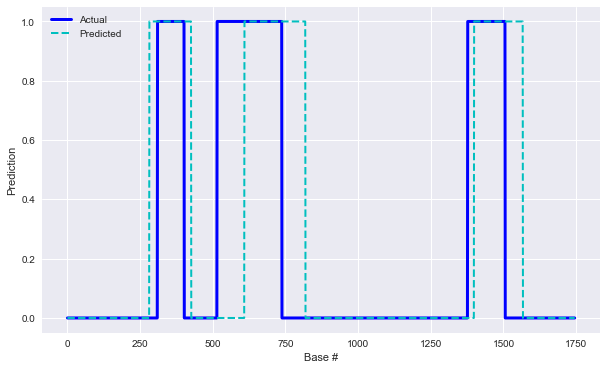

In [13]:
test_name = test_names[6]
print(test_name)
seq = sequences[test_name]['sequence']
mm2_predicted = predict_mm2(seq, mm2_transitions)

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(sequences[test_name]['is_exon'], 'b', label='Actual', lw=3)
ax.plot(mm2_predicted, 'c--', label='Predicted', lw=2)
ax.set_xlabel('Base #')
ax.set_ylabel('Prediction')
ax.legend()
plt.show()

Example 2: MMEZGL

MMEZGL


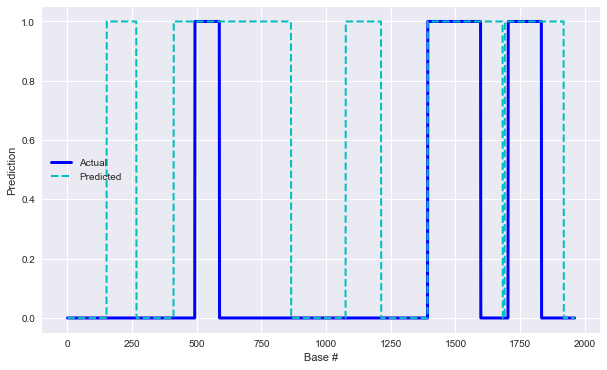

In [14]:
test_name = test_names[5]
print(test_name)
seq = sequences[test_name]['sequence']
mm2_predicted2 = predict_mm2(seq, mm2_transitions)

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(sequences[test_name]['is_exon'], 'b', label='Actual', lw=3)
ax.plot(mm2_predicted2, 'c--', label='Predicted', lw=2)
ax.set_xlabel('Base #')
ax.set_ylabel('Prediction')
ax.legend()
plt.show()

## Hidden Markov Model

In [15]:
from collections import Counter

To obtain the emission probabilities, we calculate the frequencies of the bases for introns/NCR and exons:

In [16]:
# Use counter to count bases in each segment type
counters = {'exons':Counter(), 'introns':Counter()}
for name in training_names:
    for seq_type in ['exons', 'introns']:
         for subseq in sequences[name][seq_type]:
                counters[seq_type] += Counter(subseq)
                
# Set count to a very small value to avoid 0 probability
all_states = set(counters['exons'].keys()) | set(counters['introns'].keys())
for obs_state in all_states:
    for seq_type in ['exons', 'introns']:
        if obs_state not in counters[seq_type]:
            counters[seq_type][obs_state] = 1e-4   

# Convert counts into an array
intron_emissions = np.array([item[1] for item in sorted(counters['introns'].items(), key = lambda x: x[0])])
exon_emissions = np.array([item[1] for item in sorted(counters['exons'].items(), key = lambda x: x[0])])

In [17]:
# Base/incomplete code -> state map
obs_state_map = dict(zip(sorted(all_states), range(len(all_states))))
obs_state_map

{'A': 0,
 'B': 1,
 'C': 2,
 'G': 3,
 'K': 4,
 'N': 5,
 'R': 6,
 'S': 7,
 'T': 8,
 'Y': 9}

To obtain the transition probabilities, we calculate the frequency of transitions from exons to introns/introns to exons. Transition probabilities not to itself are very small -- this is why we should use inhomogeneous/explicit duration (semi-Markov) models, since the transition proabbilities should not be the same whether you've been in a state for 5 bases or 100 bases.

In [18]:
# Hidden state 0 = intron
# Hidden State 1 = exon
transition_probability = np.zeros([2, 2])
for name in training_names:
    transition_probability[0, 1] += len(sequences[name]['indices'])//2
    transition_probability[1, 0] += len(sequences[name]['indices'])//2
    transition_probability[0, 0] += sum(len(s)-1 for s in sequences[name]['introns'])
    transition_probability[1, 1] += sum(len(s)-1 for s in sequences[name]['exons'])
transition_probability /= np.sum(transition_probability, axis=1).reshape(-1, 1)
transition_probability

array([[0.99892848, 0.00107152],
       [0.00587513, 0.99412487]])

Decoding a sequence from the test set (using Viterbi algorithm):

In [19]:
def predict_hmm(seq, transition_probability, intron_emissions, exon_emissions, obs_state_map):
    # Calculate emission probability of the bases/incomlete-codes in the sequence
    exon_probs = exon_emissions[[index for index in map(lambda base: obs_state_map[base], sorted(list(set(seq))))]]
    exon_probs = exon_probs/np.sum(exon_probs)
    intron_probs = intron_emissions[[index for index in map(lambda base: obs_state_map[base], sorted(list(set(seq))))]]
    intron_probs = intron_probs/np.sum(intron_probs)
    emission_probability = np.vstack([intron_probs, exon_probs])

    # Map the sequence into states
    obs_state_map2 = dict(zip(sorted(list(set(seq))), range(len(sorted(list(set(seq)))))))
    seq_mapped = np.array(list(map(lambda x: obs_state_map2[x], seq))).reshape(1, -1)
    
    # Initialize arrays for Viterbi
    best_states = -1 * np.ones([2, len(seq)])
    omega = -np.inf*np.ones([2, len(seq)])
    omega[0, 0] = np.log(emission_probability[0][seq_mapped[0, 0]])

    # Forward
    for obs in range(1, len(seq_mapped[0])):
        for j in range(2):
            vals = [omega[i, obs-1] + np.log(transition_probability[i, j] * emission_probability[j][seq_mapped[0, obs]])
                    for i in range(2)]
            best_states[j, obs] = np.argmax(vals)
            omega[j, obs] = vals[int(best_states[j, obs])]

    # Backward
    z = 0
    my_predicted = [z]
    for obs in range(len(seq_mapped[0])-1, 0, -1):
        z = best_states[int(z), obs]
        my_predicted.append(int(z))
    my_predicted = my_predicted[::-1]
    
    return my_predicted


Example 1

PAAFPG


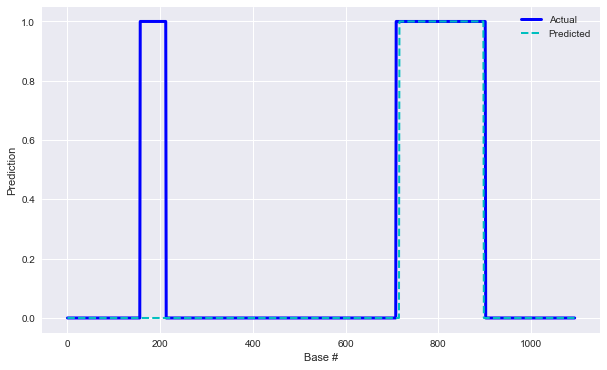

In [20]:
test_name = test_names[15]
print(test_name)
seq = sequences[test_name]['sequence']
hmm_predicted = predict_hmm(seq, transition_probability, intron_emissions, exon_emissions, obs_state_map)

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(sequences[test_name]['is_exon'], 'b', label='Actual', lw=3)
ax.plot(hmm_predicted, 'c--', label='Predicted', lw=2)
ax.set_xlabel('Base #')
ax.set_ylabel('Prediction')
ax.legend()
plt.show()

Example 2

RN3B3GLOB


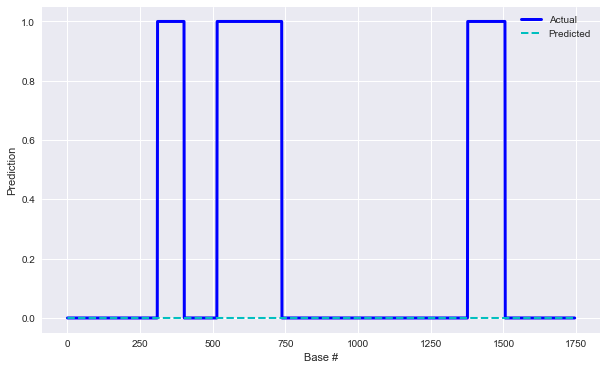

In [21]:
test_name = test_names[6]
print(test_name)
seq = sequences[test_name]['sequence']
hmm_predicted = predict_hmm(seq, transition_probability, intron_emissions, exon_emissions, obs_state_map)

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(sequences[test_name]['is_exon'], 'b', label='Actual', lw=3)
ax.plot(hmm_predicted, 'c--', label='Predicted', lw=2)
ax.set_xlabel('Base #')
ax.set_ylabel('Prediction')
ax.legend()
plt.show()

Transition probabilities (not to itself) are too small, emissions not distinctive enough.

## Rules

Predictions given above are not legal parses.

Models can be improved by filtering and processing for legal parses only.

- Start codons and stop codons; check reading frames
- Splice sites (GT-acceptor, AG-donor)
- Illegal codon (no stop codon in middle)

## Metrics

Sensitivity: $\frac{\text{TP}}{\text{TP+FN}}$

Specificity: $\frac{\text{TP}}{\text{TP+FP}}$

Correlation coefficient: $\frac{(TP)(TN) - (FP)(FN)}{\sqrt{(TP+FN)(TN+FP)(TP+FP)(TN+FN)}}$

In [22]:
def evaluate(predicted, actual):
    TP = 1. * sum((actual + predicted) == 2)
    FN = sum((actual - predicted) == 1)
    FP = sum((actual - predicted) == -1)
    TN = sum((actual + predicted) == 0)
    sensitivity = TP/(TP+FN)
    if (TP+FP) == 0:
        specificity = 0
        cc = 0
    else:
        specificity = TP/(TP+FP)
        cc = (TP*TN - FP*FN)/np.sqrt((TP+FN)*(TN+FP)*(TP+FP)*(TN+FN))
    return sensitivity, specificity, cc


Average over the test set:

In [23]:
results = {model_name:[] for model_name in ['mm1', 'mm2', 'hmm']}
for test_name in test_names:
    # print(test_name)
    seq = sequences[test_name]['sequence']
    
    # 1st order Markov chain
    mm1_predicted = predict_mm1(seq, mm1_transitions)
    metrics = evaluate(mm1_predicted, sequences[test_name]['is_exon'])
    results['mm1'].append(metrics)
    
    # 2nd order Markov chain
    mm2_predicted = predict_mm2(seq, mm2_transitions)
    metrics = evaluate(mm2_predicted, sequences[test_name]['is_exon'])
    results['mm2'].append(metrics)
    
    # HMM
    hmm_predicted = predict_hmm(seq, transition_probability, intron_emissions, exon_emissions, obs_state_map)
    metrics = evaluate(hmm_predicted, sequences[test_name]['is_exon'])
    results['hmm'].append(metrics)

In [24]:
for model_name in results:
    average_sensitivity = np.mean([x[0] for x in results[model_name]])
    average_specificity = np.mean([x[1] for x in results[model_name]])
    average_cc = np.mean([x[2] for x in results[model_name]])
    print('{}=================='.format(model_name))
    print('Avg. Sensitivity: {:.2f}%'.format(100*average_sensitivity))
    print('Avg. Specificity: {:.2f}%'.format(100*average_specificity))
    print('Avg. Correlation Coefficient: {:.2f}%'.format(100*average_cc))

mm1==================
Avg. Sensitivity: 78.09%
Avg. Specificity: 35.30%
Avg. Correlation Coefficient: 31.41%
mm2==================
Avg. Sensitivity: 81.00%
Avg. Specificity: 36.95%
Avg. Correlation Coefficient: 35.18%
hmm==================
Avg. Sensitivity: 29.39%
Avg. Specificity: 14.80%
Avg. Correlation Coefficient: 9.28%


## A More Sophisticated HMM

States:

- Upstream
- Start Codon (start1 (A) -> start2 (T) -> start3 (G))
- Exon (exon1 -> exon2 -> exon3)
- 5' splice site (5splicesite1 (G) -> 5splicesite2 (T))
- Intron
- 3' splice site (3splicesite1 (A) -> 3splicesite2 (G))
- Stop Codon (stop1 (T) -> stop2 (A/G) -> stop3 (A/G))
- Downstream

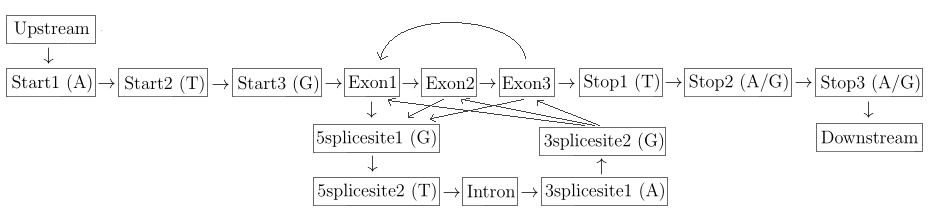

(Motivated by VEIL -- see Henderson 1997)

In [25]:
hidden_states = ['upstream', 
                 'start1', 'start2', 'start3', 
                 'exon1', 'exon2', 'exon3', 
                 '5splicesite1', '5splicesite2', 
                 'intron', 
                 '3splicesite1', '3splicesite2', 
                 'stop1', 'stop2', 'stop3', 
                 'downstream'] 
n_states = len(hidden_states)
emissions = {state: Counter() for state in hidden_states}
transitions = {state:{state2:0 for state2 in hidden_states} 
               for state in hidden_states}

Label all of the nucleotides as one of the above states.

In [26]:
def label(sequences, name):
    labelled = []
    for i in range(len(sequences[name]['introns'])):
        # i=0: downstream; label upstream, start codon, next exon
        if i == 0: 
            labelled += [0]*len(sequences[name]['introns'][0])
            labelled += [1]
            labelled += [2]
            labelled += [3]
            labelled += [4, 5, 6] * ((len(sequences[name]['exons'][i])-3)//3)
            if len(sequences[name]['exons'][i]) % 3 == 1: labelled += [4]
            if len(sequences[name]['exons'][i]) % 3 == 2: labelled += [4, 5] 
            state = labelled[-1] % 3
        # i=1,... 2nd to last intron; label intron, donor splice site, acceptor splice site, exons
        elif i < len(sequences[name]['introns']) - 2:
            labelled += [7]
            labelled += [8]
            labelled += [9]*(len(sequences[name]['introns'][i])-4)
            labelled += [10]
            labelled += [11]
            labelled += [4+state, 5+state-3*((1+state)//3), 6+state-3*((2+state)//3)] * (len(sequences[name]['exons'][i])//3)
            if len(sequences[name]['exons'][i]) % 3 == 1: labelled += [4+state]
            if len(sequences[name]['exons'][i]) % 3 == 2: labelled += [4+state, 5+state-3*((1+state)//3)] 
            state = labelled[-1] % 3
        # i = last intron; label intron, donor splice site, acceptor splice site, exons, stop codon
        elif i == len(sequences[name]['introns']) - 2:
            labelled += [7]
            labelled += [8]
            labelled += [9]*(len(sequences[name]['introns'][i])-4)
            labelled += [10]
            labelled += [11]
            labelled += [4+state, 5+state-3*((1+state)//3), 6+state-3*((2+state)//3)] * ((len(sequences[name]['exons'][i])-3)//3)
            if len(sequences[name]['exons'][i]) % 3 == 1: labelled += [4+state]
            if len(sequences[name]['exons'][i]) % 3 == 2: labelled += [4+state, 5+state-3*((1+state)//3)] 
            labelled += [12]
            labelled += [13]
            labelled += [14]
        # i = last; label downstream dna
        elif i == len(sequences[name]['introns']) - 1: 
            labelled += [15]*len(sequences[name]['introns'][i]) 

    return labelled

MLE of HMM parameters

In [27]:
for name in training_names:
    sequences[name]['label'] = label(sequences, name)
    for i in range(len(sequences[name]['label'])):
        # Count emissions
        l = sequences[name]['label'][i]
        hidden_state = hidden_states[l]
        emissions[hidden_state][sequences[name]['sequence'][i]] += 1
        # Count transitions
        if i > 0:
            prev_l = sequences[name]['label'][i-1]
            prev_hidden_state = hidden_states[prev_l]
            transitions[prev_hidden_state][hidden_state] += 1

In [28]:
emissions, transitions

({'3splicesite1': Counter({'A': 1857}),
  '3splicesite2': Counter({'G': 1857}),
  '5splicesite1': Counter({'G': 1857}),
  '5splicesite2': Counter({'T': 1857}),
  'downstream': Counter({'A': 108773,
           'C': 92204,
           'G': 90493,
           'N': 242,
           'T': 115876,
           'Y': 1}),
  'exon1': Counter({'A': 34096, 'C': 34082, 'G': 43961, 'T': 21300}),
  'exon2': Counter({'A': 42026, 'C': 30535, 'G': 26450, 'N': 1, 'T': 34427}),
  'exon3': Counter({'A': 20751, 'C': 45053, 'G': 41184, 'T': 26451}),
  'intron': Counter({'A': 295310,
           'C': 266366,
           'G': 273658,
           'K': 1,
           'N': 378,
           'R': 1,
           'S': 1,
           'T': 326432,
           'Y': 2}),
  'start1': Counter({'A': 513}),
  'start2': Counter({'T': 513}),
  'start3': Counter({'G': 513}),
  'stop1': Counter({'T': 513}),
  'stop2': Counter({'A': 274, 'G': 239}),
  'stop3': Counter({'A': 405, 'G': 108}),
  'upstream': Counter({'A': 162680,
           'B': 

In [29]:
# Calculate transition probability
transition_probability =  np.zeros([n_states, n_states])
for i in range(n_states):
    for j in range(n_states):
        transition_probability[i][j] = transitions[hidden_states[i]][hidden_states[j]]
        
# Normalize
transition_probability = transition_probability/np.sum(transition_probability, axis=1).reshape(-1, 1)
transition_probability

array([[9.99200203e-01, 7.99797217e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        9.84405458e-01, 0.00000000e+00, 0.00000000e+00, 1.559

Viterbi algo

In [30]:
def viterbi(seq, transition_probability, emissions, obs_state_map, valid_exon_path=False):
    n_components = len(emissions)
    
    # Calculate emission probability of the bases/incomlete-codes in the sequence
    seq_bases = sorted(list(set(seq)))
    emission_probability = []
    for hidden_state in emissions:
        emission_probability.append([emissions[hidden_state][base] for base in seq_bases])
    emission_probability = np.array(emission_probability)
    emission_probability = emission_probability/np.sum(emission_probability, axis=1).reshape(-1, 1)

    # Map sequence into states
    obs_state_map2 = dict(zip(sorted(list(set(seq))), range(len(sorted(list(set(seq)))))))
    seq_mapped = np.array(list(map(lambda x: obs_state_map2[x], seq))).reshape(1, -1)
    
    # Initialize arrays
    best_states = -1 * np.ones([n_components, len(seq)], dtype=np.int32)
    omega = -np.inf*np.ones([n_components, len(seq)])
    omega[0, 0] = np.log(emission_probability[0][seq_mapped[0, 0]])
    last_exons = np.zeros([n_components, len(seq)])
    last_2bases = np.empty([n_components, len(seq)], dtype=object)

    # Forward algo
    for obs in range(1, len(seq_mapped[0])):
        for j in range(n_components):
            vals = [omega[i, obs-1] + np.log(transition_probability[i, j] * emission_probability[j][seq_mapped[0, obs]])
                        for i in range(n_components)]

            # Check not stop codon
            if j == 6:
                for prev in [5, 11]:
                    two = last_2bases[prev, obs-1]
                    if two is None: continue
                    if two + seq[obs] in ['TAA', 'TAG', 'TGA']:
                        vals[prev] = -np.inf

            # Check illegal 11 -> 4/5/6 (consistent reading frame)
            if valid_exon_path:
                last_exon = last_exons[11, obs-1]
                if j in [4 + ((last_exon - 4) % 3), 4 + ((last_exon - 5) % 3)]:
                    vals[11] = -np.inf

            # Store
            best_states[j, obs] = int(np.argmax(vals))
            omega[j, obs] = vals[best_states[j, obs]]

            if j == 4:
                last_2bases[j, obs] = seq[obs]
            elif j == 5:
                if last_2bases[best_states[j, obs], obs-1] is None: continue
                last_2bases[j, obs] = last_2bases[best_states[j, obs], obs-1] + seq[obs] 
            elif j == 6:
                pass
            else:
                last_2bases[j, obs] = last_2bases[best_states[j, obs], obs-1]

            if valid_exon_path:
                if j in [4, 5, 6]:
                    last_exons[j, obs] = j
                else:
                    last_exons[j, obs] = last_exons[best_states[j, obs], obs-1]
    
    # Backward algo
    z = n_components - 1
    my_predicted = [z]
    for obs in range(len(seq_mapped[0])-1, 0, -1):
        z = best_states[int(z), obs]
        my_predicted.append(int(z))
    my_predicted = my_predicted[::-1]
    
    return my_predicted


Example 1

MMEZGL


c:\python363\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


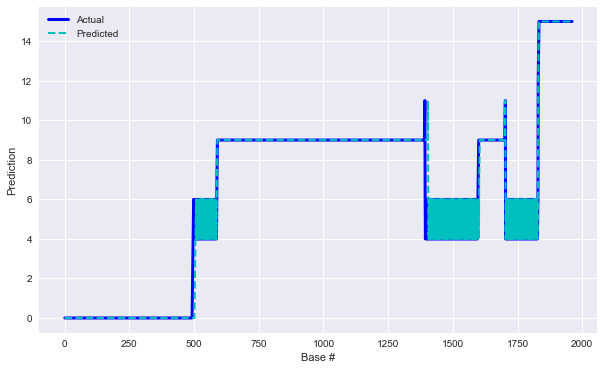

In [31]:
test_name = test_names[5]
print(test_name)
seq = sequences[test_name]['sequence']
my_predicted = viterbi(seq, transition_probability, emissions, obs_state_map)

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(label(sequences, test_name), 'b', label='Actual', lw=3)
ax.plot(my_predicted, 'c--', label='Predicted', lw=2)
ax.set_xlabel('Base #')
ax.set_ylabel('Prediction')
ax.legend()
plt.show()

Example 2

RN3B3GLOB


c:\python363\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


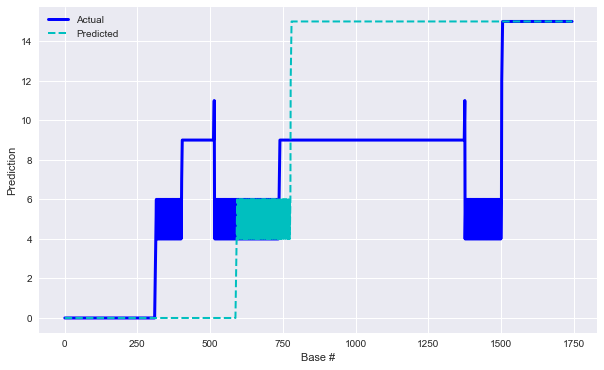

In [32]:
test_name = test_names[6]
print(test_name)
seq = sequences[test_name]['sequence']
my_predicted = viterbi(seq, transition_probability, emissions, obs_state_map)

fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(label(sequences, test_name), 'b', label='Actual', lw=3)
ax.plot(my_predicted, 'c--', label='Predicted', lw=2)
ax.set_xlabel('Base #')
ax.set_ylabel('Prediction')
ax.legend()
plt.show()

Log likelihood comparison

In [33]:
n_components = len(emissions)

# Calculate emission proabbilities
seq_bases = sorted(list(set(seq)))
emission_probability = []
for hidden_state in emissions:
    emission_probability.append([emissions[hidden_state][base] for base in seq_bases])
emission_probability = np.array(emission_probability)
emission_probability = emission_probability/np.sum(emission_probability, axis=1).reshape(-1, 1)

# Map sequence to states
obs_state_map2 = dict(zip(sorted(list(set(seq))), range(len(sorted(list(set(seq)))))))
seq_mapped = np.array(list(map(lambda x: obs_state_map2[x], seq))).reshape(1, -1)

# Compare log-likelihoods
actual_ans = label(sequences, test_name)
ll = 0
ll2 = 0
for obs in range(1, len(seq_mapped[0])):
    i = my_predicted[obs-1]
    j = my_predicted[obs]
    ll += np.log(transition_probability[i, j] * emission_probability[j][seq_mapped[0, obs]])
    i = actual_ans[obs-1]
    j = actual_ans[obs]
    ll2 += np.log(transition_probability[i, j] * emission_probability[j][seq_mapped[0, obs]])
print(ll)
print(ll2)

-2399.1610429344432
-2404.617685398384


Running over the test set:

In [34]:
hmm2_results = []
for test_name in test_names:
    print(test_name)
    seq = sequences[test_name]['sequence']

    hmm2_predicted = viterbi(seq, transition_probability, emissions, obs_state_map)
    hmm2_predicted = [i in [1, 2, 3, 4, 5, 6, 12, 13, 14] for i in hmm2_predicted]  # states part of the exon
    metrics = evaluate(hmm2_predicted, sequences[test_name]['is_exon'])
    hmm2_results.append(metrics)

BRHOX22


c:\python363\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log


LAYEGLOBIN
CHPPROTP1B
CHKRPL37A
MMGCCRYA
MMEZGL
RN3B3GLOB
HUMBETGLOR
HYPSCGH
HUMAPOCII
RABTNF
RNVEGP2C
AOIRHODOPS
S49651
U00938
PAAFPG
HSCD14G
SMNPRP1A
HUMBETGLOE
HSRPII145
HSHMG17G
MMU13921
MMU02298
HSAPOC2G
FDTNFA
RN3B2GLOB
CHKDPCP
CHPPROTP1A
XLACTA
MUSHBBH0
MMIL3G
BOVLYSOZMB
MUSOGC
RNUCPG
DMPROTP1
CHKRPL5G
CHEBGLI
MMCYTOKNA
CCALAC
OAKRT213
S69350
CHKAPOII
MMSYNDE1A
PTAZGLO
GGACTI
HSCYTOK17
HSIL1B
HUMBETGLOI
BOVCOX7AL
HUMCP21OH
HSCBMYHC
MUSHBBH1
S69278
MUSRPL30
RATKALA
HUMBETGLOK
MMPO


In [35]:
average_sensitivity = np.mean([x[0] for x in hmm2_results])
average_specificity = np.mean([x[1] for x in hmm2_results])
average_cc = np.mean([x[2] for x in hmm2_results])
print('{}=================='.format('HMM2'))
print('Avg. Sensitivity: {:.2f}%'.format(100*average_sensitivity))
print('Avg. Specificity: {:.2f}%'.format(100*average_specificity))
print('Avg. Correlation coefficient: {:.2f}%'.format(100*average_cc))

HMM2==================
Avg. Sensitivity: 38.64%
Avg. Specificity: 52.20%
Avg. Correlation coefficient: 36.24%


In [36]:
sorted(list(enumerate(hmm2_results)), key=lambda x: -abs(x[1][2]))

[(5, (0.951048951048951, 0.9902912621359223, 0.9624872507312574)),
 (16, (0.9973404255319149, 0.9715025906735751, 0.9432217481384966)),
 (42, (0.813034188034188, 0.9280487804878049, 0.8636513022469295)),
 (52, (0.734225621414914, 0.9974025974025974, 0.8077070856602825)),
 (45, (0.9792147806004619, 0.7416909620991253, 0.7979457812641921)),
 (40, (1.0, 0.845691382765531, 0.7919430602692757)),
 (18, (0.7094594594594594, 0.9264705882352942, 0.7837728115099799)),
 (47, (0.7094594594594594, 0.9264705882352942, 0.7837728115099799)),
 (55, (0.7094594594594594, 0.9264705882352942, 0.7837728115099799)),
 (15, (0.7309236947791165, 0.9238578680203046, 0.7782529334605044)),
 (21, (0.7625570776255708, 0.8820422535211268, 0.7575031378682286)),
 (56, (0.6662030598052852, 0.9077700568540745, 0.7387713147053521)),
 (50, (0.9269595176571921, 0.6910235007063054, 0.7308820491640986)),
 (25, (0.6283783783783784, 0.9858657243816255, 0.7263126215282624)),
 (36, (0.5180180180180181, 0.9829059829059829, 0.67186

Remark: inhomogeneity/semi-Markov property is definitely needed. 

Even though all the sequences from the dataset have multiple splices, some of the predictions generated by this HMM were just very short single exons.

## Some Examples of Classification Techniques

Most classification techniques rely on feature extraction/signals and scoring metrics.

### LDA/QDA

Objective: classify donor-acceptor pairs:

Acceptor: [1][2][3][4][5][6][7][8][9][10][11][12][13]AG[16][17]

Donor: [1][2][3]GT[6][7][8][9] 

Scoring Matrix/Position Weighted Matrix, based off log-odds ratios (Zhang 2000): 

In [37]:
donor_scores = np.array([
    [4.927625, 5.455039, 3.657552, -6.708694, -6.708694, 5.337298, 5.651656, 3.407280, 4.182753],  # A
    [4.940989, 3.940082, 2.771444, -6.708694, -6.708694, 2.532072, 3.429272, 3.076291, 4.177265],  # C
    [4.306864, 4.004144, 5.751008,  5.990247, -6.708694, 5.131641, 3.822682, 5.783425, 4.396518],  # G
    [3.857558, 4.083199, 3.409364, -6.708694,  5.990247, 2.271352, 3.642136, 3.126140, 5.234395]   # T
])

acceptor_scores = np.array([
    [3.880829, 3.741861, 3.642345, 3.612792, 3.426912, 3.426912, 3.328560, 3.657692, 3.700662, 3.548945, 3.426912, 4.475351, 2.8035533, 5.990254, -6.715080, 4.526246, 4.435813],
    [4.904257, 4.883169, 4.852447, 4.861092, 4.811186, 4.912976, 4.933451, 5.031327, 5.075265, 5.114224, 4.946127, 4.865121, 5.6406314,-6.715080, -6.715080, 3.950054, 4.429618],
    [3.939965, 3.961359, 3.894347, 3.809521, 3.846549, 3.757379, 3.846549, 3.894347, 3.598628, 3.290467, 3.290467, 4.444408, 0.5327123,-6.715080, 5.990254, 5.445529, 4.752387],
    [5.104587, 5.151940, 5.215812, 5.237274, 5.293456, 5.246280, 5.225385, 5.065679, 5.090574, 5.144678, 5.304566, 4.555519, 4.6018911,-6.715080, -6.715080, 3.700662, 4.947867]
])

base_mapping = {'A':0, 'C': 1, 'G':2, 'T':3}

From the training set, extract real splice sites and extract fake splice sites.

In [38]:
import re

In [39]:
reals = []
fakes = []
for name in training_names:    
    # Extract real donor acceptor pairs
    for i in range(1, len(sequences[name]['introns'])-1):
        donor = ''.join([sequences[name]['exons'][i-1][-3:], sequences[name]['introns'][i][:6]])
        acceptor = ''.join([sequences[name]['introns'][i][-15:], sequences[name]['exons'][i][:2]])
        reals.append([donor, acceptor])

    # Extract random fake donor acceptor pairs
    donor_indexes = []
    for i in re.finditer('GT', sequences[name]['sequence']):
        if i.start() not in sequences[name]['indices'] and i.start() > 3 and i.start() < len(sequences[name]['sequence']) - 6: 
            donor_indexes.append(i.start())
    acceptor_indexes = []
    for i in re.finditer('AG', sequences[name]['sequence']):
        if i.start() not in sequences[name]['indices'] and i.start() > 14 and i.end() < len(sequences[name]['sequence']) - 4: 
            acceptor_indexes.append(i.start())
    for d, a in zip(np.random.choice(donor_indexes, len(sequences[name]['introns'])-2), 
                    np.random.choice(acceptor_indexes, len(sequences[name]['introns'])-2)):
        fakes.append([sequences[name]['sequence'][d-3:d+6], sequences[name]['sequence'][a-13:a+4]])

# Take out incomplete sequences
fakes = list(filter(lambda x: len(set(x[0]) | set(x[1])) == 4, fakes))
reals = list(filter(lambda x: len(set(x[0]) | set(x[1])) == 4, reals))

We can already see the differentiation the scoring matrix provides between fakes and reals.

In [40]:
fakes_scores = np.array(list(map(lambda x: [sum(donor_scores[base_mapping[x[0][i]], i] for i in range(len(x[0]))), 
                                   sum(acceptor_scores[base_mapping[x[1][i]], i] for i in range(len(x[1])))], fakes)))
reals_scores = np.array(list(map(lambda x: [sum(donor_scores[base_mapping[x[0][i]], i] for i in range(len(x[0]))), 
                                   sum(acceptor_scores[base_mapping[x[1][i]], i] for i in range(len(x[1])))], reals)))
print('Fakes')
print(fakes_scores[:5])
print('Reals')
print(reals_scores[:5])

Fakes
[[40.659805  74.2456013]
 [46.277703  69.7073603]
 [43.040932  77.8626141]
 [37.261594  78.2235354]
 [41.987943  73.9365414]]
Reals
[[45.239384  85.1735991]
 [48.464388  85.4580794]
 [45.506522  83.8170104]
 [47.068358  86.0330964]
 [48.099673  85.7702444]]


Fit the LDA weights using `sklearn`.

In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
X = np.concatenate([fakes_scores, reals_scores])
y = np.array([0]*len(fakes_scores) + [1]*len(reals_scores))
clf = LDA()
print(clf.fit(X, y))
print(clf.means_)
print(clf.coef_)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
[[41.15010602 76.77439914]
 [47.17607805 84.52120992]]
[[1.25214004 0.81453276]]


Generate a test set of reals and fakes from the test sequences.

In [42]:
reals_test = []
fakes_test = []
for name in test_names:   
    # Extract real donor acceptor pairs
    for i in range(1, len(sequences[name]['introns'])-1):
        donor = ''.join([sequences[name]['exons'][i-1][-3:], sequences[name]['introns'][i][:6]])
        acceptor = ''.join([sequences[name]['introns'][i][-15:], sequences[name]['exons'][i][:2]])
        reals_test.append([donor, acceptor])

    # Extract random fake donor acceptor pairs
    donor_indexes = []
    for i in re.finditer('GT', sequences[name]['sequence']):
        if i.start() not in sequences[name]['indices'] and i.start() > 3 and i.start() < len(sequences[name]['sequence']) - 6: 
            donor_indexes.append(i.start())
    acceptor_indexes = []
    for i in re.finditer('AG', sequences[name]['sequence']):
        if i.start() not in sequences[name]['indices'] and i.start() > 14 and i.end() < len(sequences[name]['sequence']) - 4: 
            acceptor_indexes.append(i.start())
    for d, a in zip(np.random.choice(donor_indexes, len(sequences[name]['introns'])-2), 
                    np.random.choice(acceptor_indexes, len(sequences[name]['introns'])-2)):
        fakes_test.append([sequences[name]['sequence'][d-3:d+6], sequences[name]['sequence'][a-13:a+4]])

# Filter for valid subsequences
fakes_test = list(filter(lambda x: len(set(x[0]) | set(x[1])) == 4, fakes_test))
reals_test = list(filter(lambda x: len(set(x[0]) | set(x[1])) == 4, reals_test))

fakes_test_scores = np.array(list(map(lambda x: [sum(donor_scores[base_mapping[x[0][i]], i] for i in range(len(x[0]))), 
                                   sum(acceptor_scores[base_mapping[x[1][i]], i] for i in range(len(x[1])))], fakes_test)))
reals_test_scores = np.array(list(map(lambda x: [sum(donor_scores[base_mapping[x[0][i]], i] for i in range(len(x[0]))), 
                                   sum(acceptor_scores[base_mapping[x[1][i]], i] for i in range(len(x[1])))], reals_test)))

Predictions

In [43]:
X_test = np.concatenate([fakes_test_scores, reals_test_scores])
y_test = np.array([0]*len(fakes_test_scores) + [1]*len(reals_test_scores))
predictions = clf.predict(X_test)
predictions

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Outright accuracy:

In [44]:
sum(predictions == y_test)/len(predictions)

0.9681818181818181

Visualization

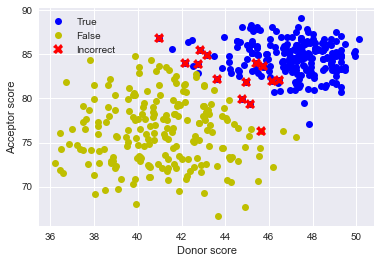

In [45]:
plt.plot(X_test[:, 0][predictions == 1], X_test[:, 1][predictions == 1], 'bo', label='True')
plt.plot(X_test[:, 0][predictions == 0], X_test[:, 1][predictions == 0], 'yo', label='False')
plt.plot(X_test[:, 0][predictions != y_test], X_test[:, 1][predictions != y_test], 'rX', markersize=10, label='Incorrect')
plt.xlabel('Donor score')
plt.ylabel('Acceptor score')
plt.legend()
plt.show()

### SVMs

Kernel: "weighted degree (WD) kernel" (Ratsch et al. 2005)
<br>    
&nbsp;&nbsp;&nbsp;&nbsp;Matches all $k$-mers for $k$= 1 to degree $d$ <br>
&nbsp;&nbsp;&nbsp;&nbsp;Match must occur at same position <br>
&nbsp;&nbsp;&nbsp;&nbsp;$\beta$ coefficients determine importance

In [46]:
def my_kernel(X, Y, d=5, betas = [1, 1, 3, 2, 2]):
    score = 0
    for k in range(d):
        for i in range(len(X)-k+1):
            if X[i:i+k] == Y[i:i+k]: 
                score += betas[k]
    return score

Construct training set of real and fake initial exon sites (-10mer-ATG-10mer-).

In [47]:
reals = []
fakes = []
for name in training_names:
    # Extract real initial exon sites
    tss = ''.join([sequences[name]['introns'][0][-10:], sequences[name]['exons'][0][:13]])
    reals.append(tss)
    
    # Extract random fake initial exon sites
    atg_indexes = []
    for i in re.finditer('ATG', sequences[name]['sequence']):
        if i.start() not in sequences[name]['indices'] and i.start() > 10 and i.start() < len(sequences[name]['sequence']) - 13: 
            atg_indexes.append(i.start())

    i = int(np.random.choice(atg_indexes, 1))
    fakes.append(sequences[name]['sequence'][i-10:i+13])

# Take out incomplete sequences
fakes = list(filter(lambda x: len(set(x)) <= 4, fakes))
reals = list(filter(lambda x: len(set(x)) <= 4, reals))
fakes = list(filter(lambda x: len(x) == 23, fakes))
reals = list(filter(lambda x: len(x) == 23, reals))
print(reals[:5])
print(fakes[:5])

['AACAGACACCATGGTGCACCTGA', 'GAGATGGGAGATGGCGCCGGTGC', 'AGAAGGGAAGATGAGTGAGTCGA', 'AACAGACACCATGGTGCACCTAA', 'CTCCTCCACCATGAAACTCGCTG']
['AAGTTTTGCTATGCTGTATTTTA', 'GAGTGGAAGGATGTCCAGGGTAT', 'GATTACAGGCATGAGTCACCTCA', 'TCTTTGTGCAATGGTCAATTGTT', 'TGCTCTGTCCATGAGCTGAGTGT']


In [48]:
X = np.array(fakes + reals).reshape(-1, 1)
Y = np.array([0]*len(fakes) + [1]*len(reals))

Construct Gram matrix for training.

In [49]:
gram_matrix = np.zeros([X.shape[0], X.shape[0]])
for i in range(X.shape[0]):
    for j in range(X.shape[0]):
        gram_matrix[i, j] = my_kernel(X[i][0], X[j][0])
gram_matrix

array([[195.,  47.,  41., ...,  49.,  77.,  43.],
       [ 47., 195.,  44., ...,  39.,  42.,  44.],
       [ 41.,  44., 195., ...,  72.,  51.,  48.],
       ...,
       [ 49.,  39.,  72., ..., 195., 106.,  58.],
       [ 77.,  42.,  51., ..., 106., 195.,  46.],
       [ 43.,  44.,  48., ...,  58.,  46., 195.]])

Use `sklearn`'s svm module.

In [50]:
from sklearn import svm
clf = svm.SVC(kernel='precomputed')
clf.fit(gram_matrix, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto',
  kernel='precomputed', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Create test set of real and fake initial exon sites.

In [51]:
reals_test = []
fakes_test = []
for name in test_names:
    tss = ''.join([sequences[name]['introns'][0][-10:], sequences[name]['exons'][0][:13]])
    reals_test.append(tss)
    
    atg_indexes = []
    for i in re.finditer('ATG', sequences[name]['sequence']):
        if i.start() not in sequences[name]['indices'] and i.start() > 10 and i.start() < len(sequences[name]['sequence']) - 13: 
            atg_indexes.append(i.start())

    i = int(np.random.choice(atg_indexes, 1))
    fakes_test.append(sequences[name]['sequence'][i-10:i+13])

# Take out incomplete sequences
fakes_test = list(filter(lambda x: len(set(x)) <= 4, fakes_test))
reals_test = list(filter(lambda x: len(set(x)) <= 4, reals_test))
fakes_test = list(filter(lambda x: len(x) == 23, fakes_test))
reals_test = list(filter(lambda x: len(x) == 23, reals_test))
print(reals_test[:5])
print(fakes_test[:5])

['TACCCTCCCAATGAGTTCCTATT', 'ACCTGACATCATGGTGCATTTTA', 'ATCCTACACCATGGCCAGGTACA', 'CACCACCACCATGTCTCTGATGA', 'AACAGACACCATGGTGCACCTAA']
['ACTTATATTAATGTGCACTGTAT', 'CTTTTGATAGATGAAAGCCTGTT', 'CCAGGTACAGATGCTGTCGCAGC', 'CCTATGAAACATGTTTTTTTCTT', 'CAGCAACCACATGGTGGCTCACA']


In [52]:
X_test = np.array(fakes_test + reals_test).reshape(-1, 1)
Y_test = np.array([0]*len(fakes_test) + [1]*len(reals_test))

Construct Gram matrix for testing

In [53]:
gram_matrix_test = np.zeros([X_test.shape[0], X.shape[0]])
for i in range(X_test.shape[0]):
    for j in range(X.shape[0]):
        gram_matrix_test[i, j] = my_kernel(X_test[i][0], X[j][0])

Predictions

In [54]:
clf.predict(gram_matrix_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Outright prediction accuracy:

In [55]:
sum(clf.predict(gram_matrix_test) == Y_test)/len(Y_test)

0.8888888888888888